<img align="center" style='max-width: 1000px' src="images/banner.png">

<img align="left" style='max-width: 150px; height: auto' src="images/hsg_logo.png">

# Lab 01 - "Meta-Learning"


## Outline

### 1. PyTorch Internals
- How does PyTorch execute tensor operations in the background?
- How does auto-diffenetiation work in PyTorch?
- What is the difference between "stateful" and "stateless" models?

### 2. Meta-Learning
- What is the obejctive in optimization-based meta-learning, and when to use it?
- Meta-learning example with (pure) PyTorch
- Meta-Learning example with `higher`

## Packages

In [1]:
!pip install 'torch>=1.12*'
!pip install higher
!pip install 'torchvision==0.10.1' --no-dependencies

In [3]:
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import torch
import torch.nn as nn

# <font color='red'>1. PyTorch Internals</font>

We want to answer these questions:
- How does the computational graph of a model work in PyTorch?
- What happens when we call `.backward()` on a tensor?
- What is a stateful vs stateless model?




### 1.1 Computational Graphs

PyTorch creates computational graphs **dynamically** on the fly.

<img align="center" width="700" src="images/augmented_computational_graph.png">

$(x_1*x_2)' = x_1'x_2+ x_1*x_2'$ <br>

The top graph in the figure above is constructed once we execute the following tensor operations:

In [26]:
# Create random tensors x1 and x2 
x1 = torch.rand(1, 5, requires_grad=True)
x2 = torch.rand(1, 5, requires_grad=True)

a = x1 * x2

y1 = torch.log(a)
y2 = torch.sin(x2)

w = y1 * y2

L = torch.sum(w)

To compute the gradients of $L$ w.r.t. $x_1$ and $x_2$, we normally call `L.backward()`. </br>
Once we call `.backward()` on $L$, the differentiation graph is generated to compute and assign the gradients, and the graphs are freed afterwards. 

In [27]:
# Initially the gradients of x1 and x2 are None
print(x1.grad)
print(x2.grad)

None
None


In [28]:
L.backward()

In [29]:
# Print the gradients of x1 and x2
print(x1.grad)
print(x2.grad)

tensor([[0.7378, 1.3342, 3.6547, 2.1465, 0.6905]])
tensor([[-1.2208, -1.4691, -1.1464, -0.6189, -1.3371]])


A second back-propagation through the model is not possible because after calling `backward()` the computational graph is freed. </br>
Soltion: set `retain_graph=True` once calling `.backward(...)` </br>
Every time we call backward, the gradients are summed.


In [30]:
# L.backward()

#### Computing gradients for particular variables directly without `.backward()`

In [31]:
# Given the same operations

x1 = torch.rand(1, 5, requires_grad=True)
x2 = torch.rand(1, 5, requires_grad=True)

a = x1 * x2

y1 = torch.log(a)
y2 = torch.sin(x2)

w = y1 * y2

L = torch.sum(w)


Now, we only want to compute $\frac{\partial L}{\partial x_1}$ <br>
We use `torch.autograd.grad` to compute the gradients of a term w.r.t. a given set of variables. <br>
Unlike `.backward()`, it does not assign gradients to the graph nodes automatically.


In [32]:
# Compute gradient of L w.r.t. x1
g_x1 = torch.autograd.grad(L, x1, retain_graph=True)  # we keep the graph of the model to use it later 
 
print(g_x1)

(tensor([[0.0589, 1.8500, 0.3180, 2.7312, 0.3423]]),)


In [33]:
print(x1.grad)

None


In [34]:
# Now we compute the gradient of the model for later use
g_x2 = torch.autograd.grad(L, x2, retain_graph=True)  # we keep the graph of the model to use it later 

print(g_x2)

(tensor([[-2.8142, -1.1976, -1.4137, -0.3581, -2.7239]]),)


### 1.2 Model definition in PyTorch

#### >>Stateful<< model definition
What we normally do:

- Define the model class
- Feed an input to the model
- Compute the loss
- Backpropagate
- Update the model using the compute gradients

In [35]:
class StatefulMLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Model layers
        self.linear1 = nn.Linear(10, 5)
        self.linear2 = nn.Linear(5, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Forward steps
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

In stateful models, the weights of the model are embedded within the model!

In [36]:
# Create and instance of the model
model_stateful = StatefulMLP()

# Create random tensor
x = torch.randn(8, 10)

# Make perdiction with the model using only x
out = model_stateful(x)

print(out)

tensor([[-0.1416],
        [ 0.0937],
        [ 0.3188],
        [-0.2241],
        [-0.2170],
        [-0.0693],
        [ 0.2295],
        [-0.3512]], grad_fn=<AddmmBackward0>)


#### >>Stateless<< model definition


Stateful models are ideal for most use cases, however, we may need stateless execution for some cases, for example:

- When the weights of the model are generated by another networks (Hyper-Networks)
- When we want to compute the gradient of a term over an optimization trajectory

<img align="center" width="900" src="images/stateless_applications.png">


In stateless model defnitions, the model weights are not defined inside the model. Instead, they are provided through the forward function.

PyTorch functionals: https://pytorch.org/docs/stable/nn.functional.html


In [37]:
import torch.nn.functional as F

In [38]:
class StatelessMLP(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, params):
        # The forward function is defined in a different way
        # The model weights (parmeters) are given as an input to the forward function
        # We assume the model weights are given as a dictionary
        # Now we use PyTorch functionals to execute the graph operations
        x = F.linear(x, params["w1"])
        x = F.relu(x)
        x = F.linear(x, params["w2"])

        return x

How do functionals works? </br>
Example:
we can use `torch.nn.functional.linear` to apply a linear transformation, i.e: $xw^T$

In [39]:
# Input: 8 x 10
# Transformation: 10 x 5
# Output: 8 x 5

# Input
x = torch.randn(8, 10)

# Weights
w = torch.ones(5, 10)

# Functional
out = F.linear(x, w)
print("Output shape is: ", out.shape)

Output shape is:  torch.Size([8, 5])


How to use a statelss model defintion?


In [40]:
# Define model
model_stateless  = StatelessMLP()

# Model input
x = torch.randn(8, 10)

# Model parameters (weights)
params = {
    "w1": torch.randn(5, 10),
    "w2": torch.randn(1, 5)
}

# Make prediction
out = model_stateless(x, params)

print(out.shape)

torch.Size([8, 1])


#### Creating a stateless model from a stateful model

- Defining model operations manually can be cumbersome for large models
- Given a regular pytorch model, we want to define a stateless model without re-defining the forwrad function

In PyTorch `1.12`, a new features was added for this purpose 

In [41]:
from torch.nn.utils.stateless import functional_call

In [42]:
# Using the previously defined StatefulMLP 
model1 = StatefulMLP()
model2 = StatefulMLP()

# create random tensor
x = torch.randn(8, 10)

# Use the weights of model2 to make prediction
params = dict(model2.named_parameters())
print(params.keys())

# Make prediction statelessly
pred = functional_call(model1, params, x)
print(pred.shape)


dict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])
torch.Size([8, 1])


### 1.3 Manually assigning gradients to a model

When we call `loss.backward()`, PyTorch automatically computes gradients and assigns them to the model's parameters. </br>
However, when the gradients are calculated via `torch.autograd.grad()`, we need to assign them manually.

In [43]:
# Using the previously defined StatefulMLP 
model = StatefulMLP()

# Zero all gradients
model.zero_grad() 

# create random tensor
x = torch.randn(8, 10)

# Forward propagation
pred = model(x)

# Compute loss and gradients
loss = torch.mean(pred)
grads = torch.autograd.grad(loss, model.parameters())

In [44]:
print("Gradients before assignment")
for p in model.parameters():
    print(p.grad)

# Assign the gradients to the model's parameters
for (p, g) in zip(model.parameters(), grads):
    p.grad = g
    

print("\nGradients after assignment")
for p in model.parameters():
    print(p.grad)
    

Gradients before assignment
None
None
None
None

Gradients after assignment
tensor([[-0.1976,  0.0801, -0.0960, -0.1143, -0.0647,  0.1583, -0.0009, -0.1294,
          0.0461, -0.0447],
        [ 0.1430, -0.1169,  0.0519,  0.0568, -0.0583, -0.0806,  0.0270,  0.0296,
          0.0137,  0.0477],
        [ 0.0008, -0.0016,  0.0003, -0.0070, -0.0019,  0.0065,  0.0008, -0.0078,
          0.0008, -0.0026],
        [ 0.0193,  0.0427,  0.0028, -0.0222, -0.0519,  0.0623,  0.0128, -0.0151,
         -0.0356, -0.0568],
        [-0.1758,  0.1533, -0.1838, -0.0254, -0.0235,  0.1528, -0.0769,  0.0013,
         -0.0675, -0.0701]])
tensor([ 0.3558, -0.1809,  0.0101,  0.0525,  0.2513])
tensor([[0.2192, 0.2037, 0.3746, 0.0092, 0.4317]])
tensor([1.])


Now, we are familiar with all tools and techniques to implement and train a meta-model :)

# <font color='red'>2. Meta-Learning</font>

- What is optimization-based meta-learning and when to use meta-learning?

In simple words: meta-learning aims to learn the common knowledge in a distribution of tasks.


## 2.1 Sine-Wave Example

Let's start with an example where we have a distribution of sine wave prediction tasks. We want to use a set of these tasks to learn the common knowledge among them and use that knowledge (representation) to adapt to new tasks from the same distribution using very few samples.

In [45]:
# Code adapted from https://github.com/vmikulik/maml-pytorch

class SineTask():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    
    def __init__(self, amplitude, phase, xmin, xmax):
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax
        
    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        
        return self.amplitude * np.sin(self.phase + x)
        
    def sample_data(self, size=1):
        """
        Sample data from this task.
        
        returns: 
            x: the feature vector of length size
            y: the target vector of length size
        """
        
        x = np.random.uniform(self.xmin, self.xmax, size)
        y = self.true_function(x)
        
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float).unsqueeze(1)
        
        return x, y

class SineTaskDistribution():
    """
    The task distribution for sine regression tasks for MAML
    """
    
    def __init__(self, amplitude_min, amplitude_max, phase_min, phase_max, x_min, x_max):
        self.amplitude_min = amplitude_min
        self.amplitude_max = amplitude_max
        self.phase_min = phase_min
        self.phase_max = phase_max
        self.x_min = x_min
        self.x_max = x_max
        
    def sample_task(self):
        """
        Sample from the task distribution.
        
        returns:
            Sine_Task object
        """
        amplitude = np.random.uniform(self.amplitude_min, self.amplitude_max)
        phase = np.random.uniform(self.phase_min, self.phase_max)
        return SineTask(amplitude, phase, self.x_min, self.x_max)

#### A distribution of sine wave regression tasks

We define a distribution of sine wave tasks where each task is a regression task. </br>
Different tasks are different in terms of amplitude and phase.
We first initialize the `SineTaskDistribution` with predefine parameters. For example we set the range of amplitude to [0.1, 5.0] and of phase to [0.0, $\pi$].

In [46]:
# Define task distribution for the given parameters
task_dist = SineTaskDistribution(
    amplitude_min=0.1, 
    amplitude_max=5, 
    phase_min=0, 
    phase_max=np.pi, 
    x_min=-5, 
    x_max=5
)

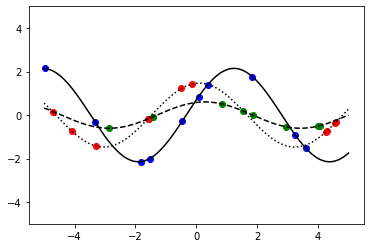

In [47]:
def plot_task(task, linestyle="solid", color="blue"):
    """ Plots the ground-truth sine function with its
    sampled datapoints.
    """
    # Plot ground-truth sine function
    gt_x = np.linspace(task.xmin, task.xmax, 1000)
    gt_y = task.amplitude * np.sin(gt_x + task.phase)
    plt.plot(gt_x, gt_y, c='black', linestyle=linestyle)
    plt.ylim([-5, 5])
    
    # Plot randomly sampled datapoints
    x, y = task.sample_data(10)
    plt.scatter(x.numpy().reshape(-1), y.numpy().reshape(-1), c=color)
    
# Sample a random task and plot it
task = task_dist.sample_task()
plot_task(task, linestyle="solid", color="blue")

# Another random task
task = task_dist.sample_task()
plot_task(task, linestyle="dashed", color="green")

# Another random task
task = task_dist.sample_task()
plot_task(task, linestyle="dotted", color="red")


### 2.1.1 Objective

We can sample an arbitrary number of tasks from the task distribution for both training and testing.

**Goal**: to train a model that can quickly estimate any sine wave given a handful of samples from it. <br>
**Solutions**:
 - 1 - Train a model on a large set of tasks with regular supervied training.
 - 2 - Train a meta-model to learn the commonality between the tasks for quick adaptation.

In [48]:
class MLP(nn.Module):
    """ Defnition of Sine wave estimator model."""
    def __init__(self):
        super().__init__()
        
        # Model layers
        self.layers = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
  
    def forward(self, x):
        return self.layers(x)


### 2.1.2 Supervised pre-training [Approach 1]

In supervised pre-training, we sample a task in each step. Then we compute the loss and gradient for the sampled task and use it to upade the model. 

<img align="center" width="900" src="images/supervised_pretraining.png">

In [49]:
def pretrained_supervised(n_iterations=1000, device=torch.device("cpu")):
    """ Pretrains a model on a distribution of tasks in a supervised manner.
    
        n_iterations: number of iterations.
    """
    # Define model, optimizer and criterion
    model = MLP()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # Progress bar
    progress = tqdm.tqdm(range(n_iterations))
    
    # List to store losses
    losses = []
    
    for itr in progress:
        # Sample a task
        task = task_dist.sample_task()

        # Extract datapoints and convert to compute device
        x, y = task.sample_data(10)
        x, y = x.to(device), y.to(device)

        # Reset model gradients
        model.zero_grad()

        # Make prediction and compute loss
        pred = model(x)
        loss = criterion(pred, y)

        # Compute gradients and update model
        loss.backward()
        optimizer.step()
        
        # Log loss value
        if itr % 10 == 0:
            losses.append(loss.item())

        progress.set_description(f"Loss: {loss.item():0.4f}")
        progress.update()

    # Plot loss curve
    plt.plot(list(range(len(losses))), losses)  
    
    return model

Loss: 12.8014: 100%|██████████| 10000/10000 [00:19<00:00, 511.90it/s]


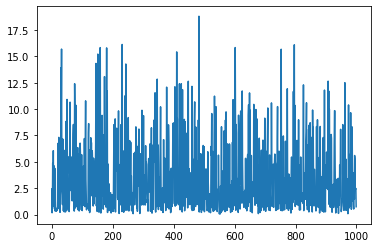

In [50]:
model_pretrained = pretrained_supervised(n_iterations=10000)

### 2.1.3 Meta-learning (MAML) [Approach 2]

<img align="center" width="900" src="images/meta_learning.png">


In [51]:
def apply_grad(params, grad):
    for p, g in zip(params, grad):
        p.grad = g
  

def inner_loop(task, model, criterion, device):
    """ Implements the inner loop of a meta-learning task.
    """
    params_initial = deepcopy(dict(model.named_parameters()))
    lr_inner = 0.01

    # Sample data for meta-train train-set
    x_train, y_train = task.sample_data(10)
    x_train, y_train = x_train.to(device), y_train.to(device)

    # Update model for one SGD step
    pred = functional_call(model, params_initial, x_train)
    loss = criterion(pred, y_train)
    grad = torch.autograd.grad(loss, params_initial.values(), retain_graph=True)
    apply_grad(params_initial.values(), grad)
    params_updated = {
      n: p - lr_inner * g for ((n, p), g) in zip(params_initial.items(), grad)
    }

    # Use the updated parameters to compute meta-train test loss
    x_test, y_test = task.sample_data(10)
    x_test, y_test = x_test.to(device), y_test.to(device)
    pred_test = functional_call(model, params_updated, x_test)
    loss_test = criterion(pred_test, y_test)

    grad = torch.autograd.grad(loss_test, params_initial.values())

    return grad, loss_test


def meta_train_maml(n_iterations=1000, n_meta_tasks=10, device=torch.device("cpu")):
    """ Meta-trains a model on a distribution of tasks.
        n_iterations: number of iterations.
        n_meta_tasks: number of tasks in each iterations.
    """
    # Define model, optimizer and criterion
    model = MLP()
    model.to(device)
    criterion = nn.MSELoss()
    optimizer_meta = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Progress bar
    progress = tqdm.tqdm(list(range(n_iterations)))
    
    # List of meta-losses
    meta_losses = []
    
    # Iterate for n_iteration times
    for itr in progress:
        # Zero all gradients
        model.zero_grad()
        
        # List to store meta-gradients for tasks at step `itr`
        meta_batch_grads = []
        
        # List to store meta-gradients at step `itr`
        meta_batch_losses = []
        
        # Iterate for `n_meta_tasks` times
        for i in range(n_meta_tasks):
            # Sample a random task
            task = task_dist.sample_task()
            
            # Compute the gradient and loss in the inner loo
            grad, loss = inner_loop(task, model, criterion, device)

            meta_batch_grads.append(grad)
            meta_batch_losses.append(loss.item())
        
        # Compute the mean of gradients over the sampled tasks
        meta_loss = sum(meta_batch_losses) / len(meta_batch_losses)
        meta_grad = [sum(g) / len(g) for g in zip(*meta_batch_grads)]
        
        # Assign the meta-gradients to the meta-model
        apply_grad(model.parameters(), meta_grad)
        
        # Update meta-model
        optimizer_meta.step()
        
        # Log meta-loss
        if itr % 10 == 0:
            meta_losses.append(meta_loss)
        progress.set_description(f"Meta-loss: {meta_loss:0.2f}")
        progress.update()

    plt.plot(list(range(len(meta_losses))), meta_losses)
    return model

Meta-loss: 0.47: 100%|██████████| 10000/10000 [02:21<00:00, 70.59it/s]


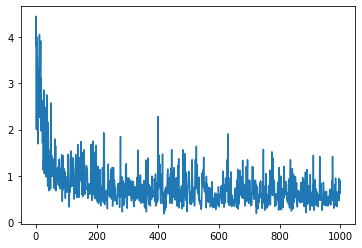

In [52]:
model_meta = meta_train_maml(n_iterations=10000, n_meta_tasks=10)

### 2.1.4 After Training: Model Adaptation Phase

Once the model is trained, we test the model with a new sine wave task. First we adapt the model to the new task using very few samples and SGD steps, then use the adapted model for prediction. 

In [53]:
def adapt_model(model_original, x, y, n_steps=1):
    """ Adapts a model using samples (x, y) with n steps of SGD.
    
        model_original: trained model
        x, y: data samples
        n_steps: number of gradient descent steps
    """
    # Make a copy of the model to avoid changes to the original model
    model = deepcopy(model_original)
    
    # Set model train mode
    model.train()
    
    # Optimizer and criteiron for adaptation
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # Adapt the model for n steps
    for i in range(n_steps):
        model.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
    
    return model

Plot results for adapted model </br>
For adaptation, we randomly sample a task from the task distribution and then randomly sample n data-points to adapt the model. <br>
The number of samples (n), determines the number of shots, therefore we say the problem is an n-shot learning problem.

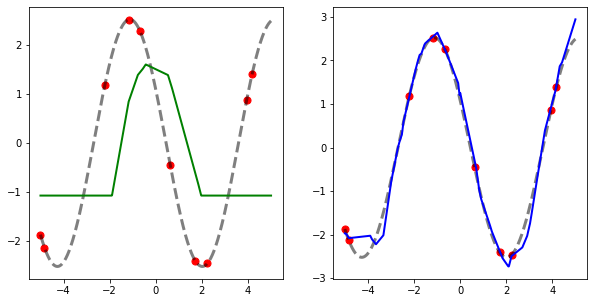

In [56]:
device = torch.device("cpu")

# Sample a random task
task = task_dist.sample_task()
x, y = task.sample_data(10)
x, y = x.to(device), y.to(device)

# Adapt the supervised pre-trained model and set eval mode on
model_pretrained_adapted = adapt_model(model_pretrained, x, y, n_steps=5)
model_pretrained_adapted.eval()

# Adapt the meta-model and set eval mode on
model_meta_adapted = adapt_model(model_meta, x, y, n_steps=5)
model_meta_adapted.eval()

# ==============================> Plot results

# Create sub-plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# -----> Plot supervised-pretrained model results
# GT
gt_x = np.linspace(task.xmin, task.xmax, 1000)
gt_y = task.amplitude * np.sin(gt_x + task.phase)
ax[0].plot(gt_x, gt_y, c='black', linewidth=3.0, linestyle="dashed", alpha=0.5)
ax[0].scatter(x.cpu().numpy().reshape(-1), y.cpu().numpy().reshape(-1), c='red', s=50)

# Prediction
gt_x_tensor = torch.FloatTensor(gt_x).unsqueeze(1).to(device)
pred_pretrained = model_pretrained_adapted(gt_x_tensor).detach().cpu().squeeze().numpy()
ax[0].plot(gt_x, pred_pretrained, c='green', linewidth=2.0)


# -----> Plot meta-model results

# GT
gt_x = np.linspace(task.xmin, task.xmax, 1000)
gt_y = task.amplitude * np.sin(gt_x + task.phase)
ax[1].plot(gt_x, gt_y, c='black', linewidth=3.0, linestyle="dashed", alpha=0.5)
ax[1].scatter(x.cpu().numpy().reshape(-1), y.cpu().numpy().reshape(-1), c='red', s=50)

# Prediction
gt_x_tensor = torch.FloatTensor(gt_x).unsqueeze(1).to(device)
pred_meta = model_meta_adapted(gt_x_tensor).detach().cpu().squeeze().numpy()
ax[1].plot(gt_x, pred_meta, c='blue', linewidth=2.0)
